<div align="center"><h1>Control Engineering Basics</h1>
<br><b>Dr.Varodom Toochinda</b>
<br>Dept. of Mechanical Engineering, Kasetsart University</div>

### Supplement to Module 6-7 : Implementing a general discrete-time transfer function (OOP approach)

<a href="https://colab.research.google.com/github/dewdotninja/control_python/blob/master/discrete_implement_oop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<b>Requirement : </b> Python 3 with Python control systems library
<p />Execute the commands below to install Python control systems library in Colab    

In [ ]:
!pip install control

In [2]:
import control as ctl 
import numpy as np
import matplotlib.pyplot as plt

**Note :** The materials below uses object-oriented approach. For basic methods, see 
[discrete_implement.ipynb](discrete_implement.ipynb)

In this notebook, we discuss the process of implementing a general discrete-time system
represented by transfer function in Z-domain. It is first converted to difference equation. 
The step response is then simulated and compared to the continuous-time counterpart of 
the same system. 

Here we make use of the direct-form II (DF II) in figure 1, which reduces the size of state 
vectors by half [1]. 

!["Fig 1"](https://drive.google.com/uc?id=1TKxFPmO37T_HH3KNn_FUD3BzVh6PXEvE)

Figure 1 conversion from direct-form I to direct-form II 

In the example below, we demonstrate the process of converting both the plant and controller 
to difference equations, then perform discrete-time simulation of the feedback system 
for each time step. 
In a real control situation, you're more likely to implement only the discrete-time controller, 
and form a closed-loop system with some physical plant. Anyway, plant simulation may be useful 
in preliminary testing phase.


#### Example 1

Suppose we want to simulate a third order-lag plant
$$
P(s) = \frac{1}{(s+1)^3},
$$


In [3]:
s = ctl.tf("s")
P = 1/(s+1)**3
P

TransferFunction(array([1]), array([1, 3, 3, 1]))

with PID feedback. The PID controller is represented by
$$
C(s) = K_p + \frac{K_i}{s} + \frac{NK_d}{N/s+1}
$$

which can be written as a function below.

In [4]:
def PID(kp, ki,kd,N):
    s = ctl.tf("s")
    C = kp + ki/s + kd*s*N/(s+N)
    return C

Using this set of parameters to construct the controller.

In [5]:
Kp = 4.8
Ki = 2.6
Kd = 2.2
N = 100
C = PID(Kp,Ki,Kd,N)
C

TransferFunction(array([224.8, 482.6, 260. ]), array([  1, 100,   0]))

Simulate the step response in continuous time to make sure that we get a stable closed-loop 
with acceptable performance

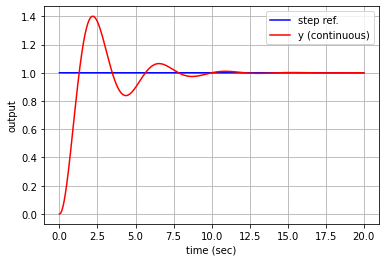

In [6]:
tvec = np.arange(0,20,0.01)
r = np.ones(tvec.shape)
L = C*P
sys = ctl.feedback(L)
tv, y = ctl.step_response(sys, tvec)

plt.figure()
plt.plot(tv,r,'b',tv,y,'r-')
plt.grid('True')
plt.xlabel('time (sec)')
plt.ylabel('output')
plt.legend(['step ref.','y (continuous)'])
plt.show()


Discretize the continuous-time transfer function using Python control library. 
You can change sampling period if you wish, but it should match the step in the time vector 
during simulation, or the loop period in MCU implementation.

In [7]:
Ts = 0.01 # second
Pd = ctl.sample_system(P, Ts, method='tustin')
Pd

TransferFunction(array([1.23143595e-07, 3.69430784e-07, 3.69430786e-07, 1.23143594e-07]), array([ 1.        , -2.97014925,  2.94059553, -0.97044529]), 0.01)

Extract the numerator and denominator coefficients from the transfer function.

In [8]:
Pdnum, Pdden = ctl.tfdata(Pd)
pdnum = np.squeeze(np.array(Pdnum))
pdden = np.squeeze(np.array(Pdden))
print("plant numerator coefficients = "+str(pdnum))
print("plant denominator coefficients = "+str(pdden))

plant numerator coefficients = [1.23143595e-07 3.69430784e-07 3.69430786e-07 1.23143594e-07]
plant denominator coefficients = [ 1.         -2.97014925  2.94059553 -0.97044529]


Note that the pdnum and pdden vectors should have same length. In rare cases that they differ, 
you may have to patch the numerator coefficient with zero in order to run the code in this 
notebook without error.

Apply the same process for PID controller.


In [10]:
Cd = ctl.sample_system(C, Ts, method='tustin')
Cdnum, Cdden = ctl.tfdata(Cd)
cdnum = np.squeeze(np.array(Cdnum))
cdden = np.squeeze(np.array(Cdden))
print("controller numerator coefficients = "+str(cdnum))
print("controller denominator coefficients = "+str(cdden))

controller numerator coefficients = [ 151.47966667 -299.72466667  148.26233333]
controller denominator coefficients = [ 1.         -1.33333333  0.33333333]


Define a class named DF2 to handle the discrete-time implementation.

In [25]:
class DF2:
    def __init__(self,num,den,ts):
        self.num = num
        self.den = den
        self.ts = ts  # keep sampling time for reference only.
        self.order = len(self.den)
        self.states = np.zeros((self.order,1))
        self.y = 0.0
        
    def state_update(self): # update state vectors
        for k in range(self.order-1):
            self.states[self.order-k-1] = self.states[self.order-k-2]
    
    def reset(self):
        for k in range(self.order-1):
            self.states[k] = 0.0
    
    def out(self, u): # compute output
        self.states[0] = u
        y = self.num[0]*u
        for k in range(self.order-1):
            self.states[0] = self.states[0] -self.den[k+1]*self.states[k+1]
            y = y + (self.num[k+1] - self.num[0]*self.den[k+1])*self.states[k+1]   
        return y
        

Create instances of discrete-time plant and controller.  

In [26]:
p_df2 = DF2(pdnum,pdden, Ts)
c_df2 = DF2(cdnum,cdden,Ts)

Perform the discrete-time simulation and plot the result.

In [20]:
# tvec is created above
r_vec = np.ones(tvec.shape)
u_vec = np.zeros(tvec.shape)
y_vec = np.zeros(tvec.shape)

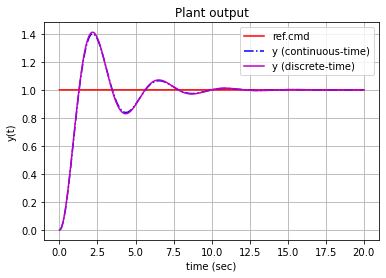

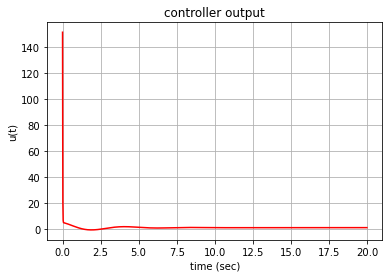

In [27]:
i = 0
# reset states at the beginning so that you can run this cell
# as often as you like.
p_df2.reset()
c_df2.reset()
# perform discrete-time simulation 
for i in range(len(tvec)):
    
    # update controller and plant states
    p_df2.state_update()
    c_df2.state_update()
    if i==0:
        e = r_vec[i]
    else:
        e = r_vec[i] - y_vec[i-1]

    u_vec[i] = c_df2.out(e) # compute controller output 
    y_vec[i] = p_df2.out(u_vec[i]) # compute plant output

plt.figure()
plt.plot(tvec,r_vec,'r-',tvec, y,'b-.',tvec,y_vec,'m-')
plt.grid('True')
plt.xlabel('time (sec)')
plt.ylabel('y(t)')
plt.legend(['ref.cmd','y (continuous-time)','y (discrete-time)'])
plt.title("Plant output")
plt.show()

plt.figure()
plt.plot(tvec,u_vec,'r-')
plt.grid('True')
plt.xlabel('time (sec)')
plt.ylabel('u(t)')
plt.title("controller output")
plt.show()    

<h3>References</h3>
<ol>
<li>V. Toochinda, Feedback Control with Scilab and Arduino, dew.ninja. 2016</li>

</ol>

<div align="right">Last update : October 23, 2022</div>

<p align="center">
<img src="https://drive.google.com/thumbnail?id=13bzT7Rmy3bzvE7TiS0yfQo94kpxMuipF" alt="dewninja"/>
</p>
<div align="center">dew.ninja<br>Copyright 2021</div>